In [1]:
import importlib
import sys
from pathlib import Path

import dotenv
import hydra
import pytorch_lightning as pl
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from inz.data.data_module import XBDDataModule
from inz.data.event import Event, Hold, Tier1, Tier3, Test
from inz.util import show_masks_comparison
from PIL import Image
from torchvision.utils import draw_segmentation_masks, make_grid  # type: ignore[import-untyped]
from torchvision.io import read_image  # type: ignore[import-untyped]

sys.path.append("inz/farseg")
sys.path.append("inz/dahitra")

In [2]:
dotenv.load_dotenv()
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)
device = torch.device("cuda")
torch.set_float32_matmul_precision("high")

Seed set to 123


In [3]:
# FarSeg double
# CKPT_PATH = "/home/tomek/inz/inz/saved_checkpoints/runs/farseg-double/checkpoints/experiment_name-0-epoch-39-step-39000-f1-0.660326-best-f1.ckpt"
# CONFIG_PATH = "../saved_checkpoints/runs/farseg-double/.hydra"

# FarSeg single
# CKPT_PATH = "/home/tomek/inz/inz/saved_checkpoints/runs/farseg_single/2024-10-25_00-48-01/checkpoints/experiment_name-0-epoch-28-step-28275-challenge_score_safe-0.6489-best-challenge-score.ckpt"
# CONFIG_PATH = "../saved_checkpoints/runs/farseg_single/2024-10-25_00-48-01/.hydra"

# Baseline double
CKPT_PATH = "/home/tomek/inz/inz/outputs/split_wind_test_hurricane_matthew_baseline/2024-11-06_05-02-23/checkpoints/experiment_name-0-epoch-12-step-1560-challenge_score_safe-0.6650-best-challenge-score.ckpt"
CONFIG_PATH = "../outputs/split_wind_test_hurricane_matthew_baseline/2024-11-06_05-02-23/.hydra"

# Baseline single
# CKPT_PATHTH = ". = "/home/tomek/inz/inz/saved_checkpoints/runs/baseline_singlebranch/baseline_singlebranch_ckpt/baseline_singlebranch-epoch=33-step=16592-challenge_score_safe=0.639932-best-challenge-score.ckpt"
# CONFIG_PA./saved_checkpoints/runs/baseline_singlebranch/.hydra_lol"


BATCH_SIZE = 1

# region misc

from hydra import compose, initialize

with initialize(version_base="1.3", config_path=CONFIG_PATH):
    cfg = compose(config_name="config", overrides=[])

model_class_str = cfg["module"]["module"]["_target_"]
model_class_name = model_class_str.split(".")[-1]
module_path = ".".join(model_class_str.split(".")[:-1])
imported_module = importlib.import_module(module_path)
model_class = getattr(imported_module, model_class_name)
model_partial = hydra.utils.instantiate(cfg["module"]["module"])

model = model_class.load_from_checkpoint(CKPT_PATH, *model_partial.args, **model_partial.keywords).to(device)
model.eval()

dm = XBDDataModule(
    path=Path("data/xBD_processed_512"),
    drop_unclassified_channel=True,
    split_events={
        "test": {
            Tier1: [
                Event.hurricane_matthew,
                Event.hurricane_michael,
            ],
            Test: [
                Event.hurricane_matthew,
                Event.hurricane_michael,
            ],
            Hold: [
                Event.hurricane_matthew,
                Event.hurricane_michael,
            ],
        }
    },
    train_batch_size=BATCH_SIZE,
    val_batch_size=BATCH_SIZE,
    test_batch_size=BATCH_SIZE,
)
dm.prepare_data()
dm.setup("test")

print(f"{len(dm.test_dataloader())} test batches")

# endregion

PREDS_DIR = Path(f"preds/{cfg['experiment_name']}")
Path.mkdir(Path("preds/"), exist_ok=True)
Path.mkdir(PREDS_DIR, exist_ok=True)

using weights from ResNet34_Weights.IMAGENET1K_V1
3820 test batches


In [4]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [5]:
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = mask
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, :] * self.mask).sum()

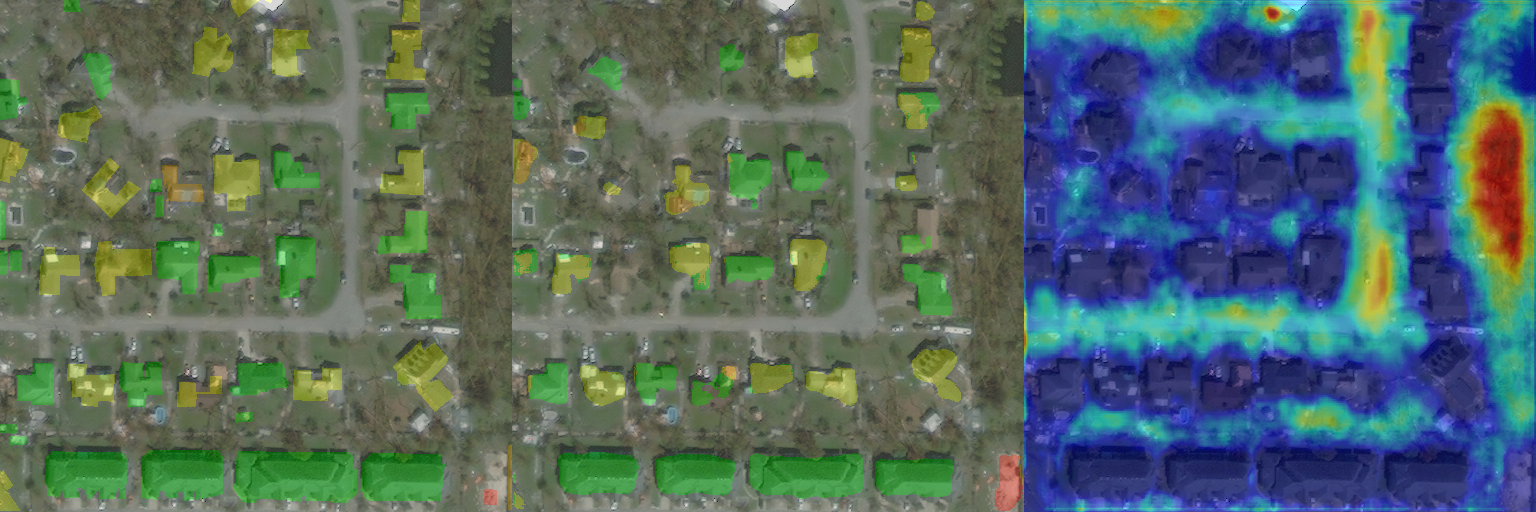

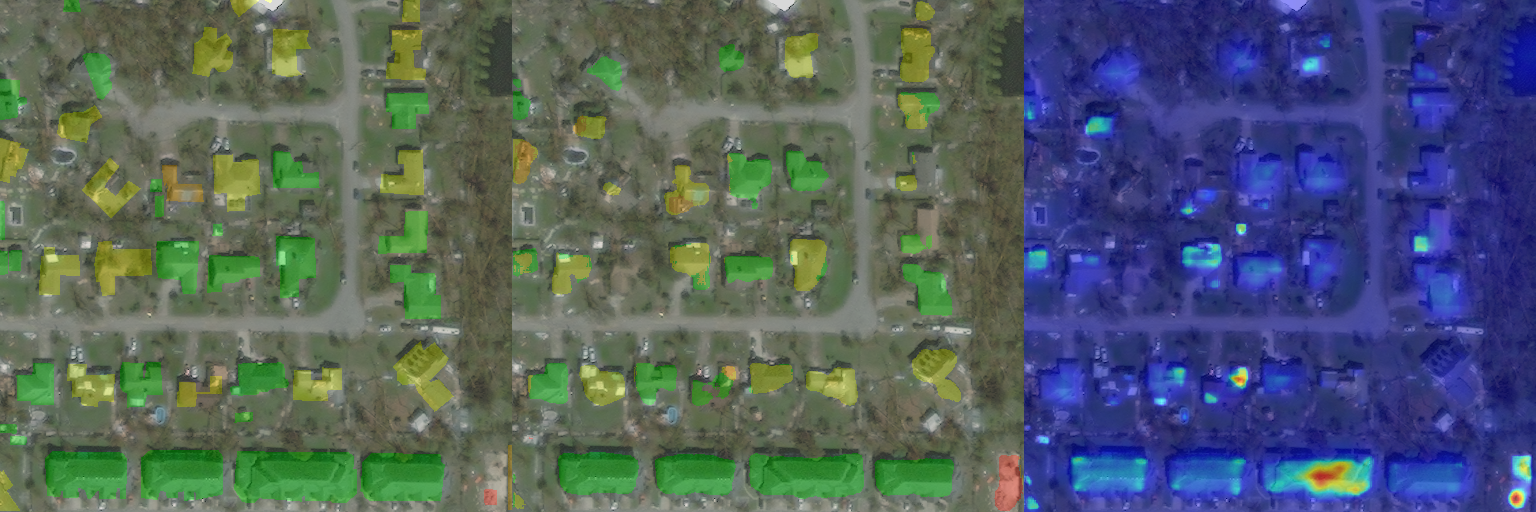

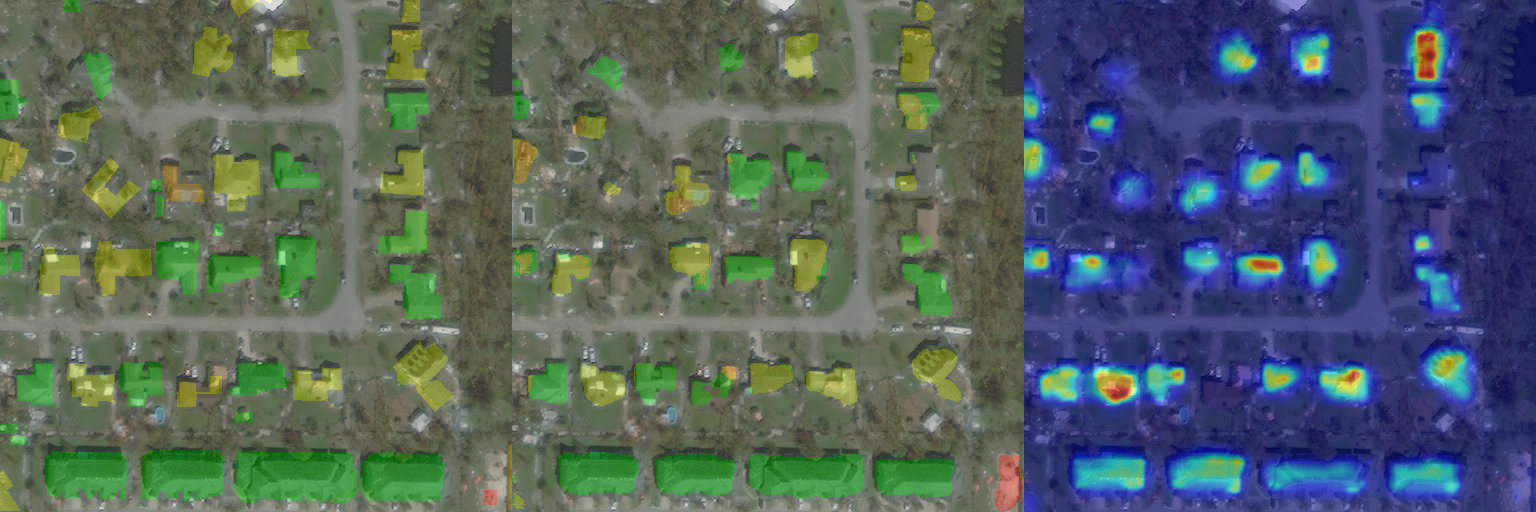

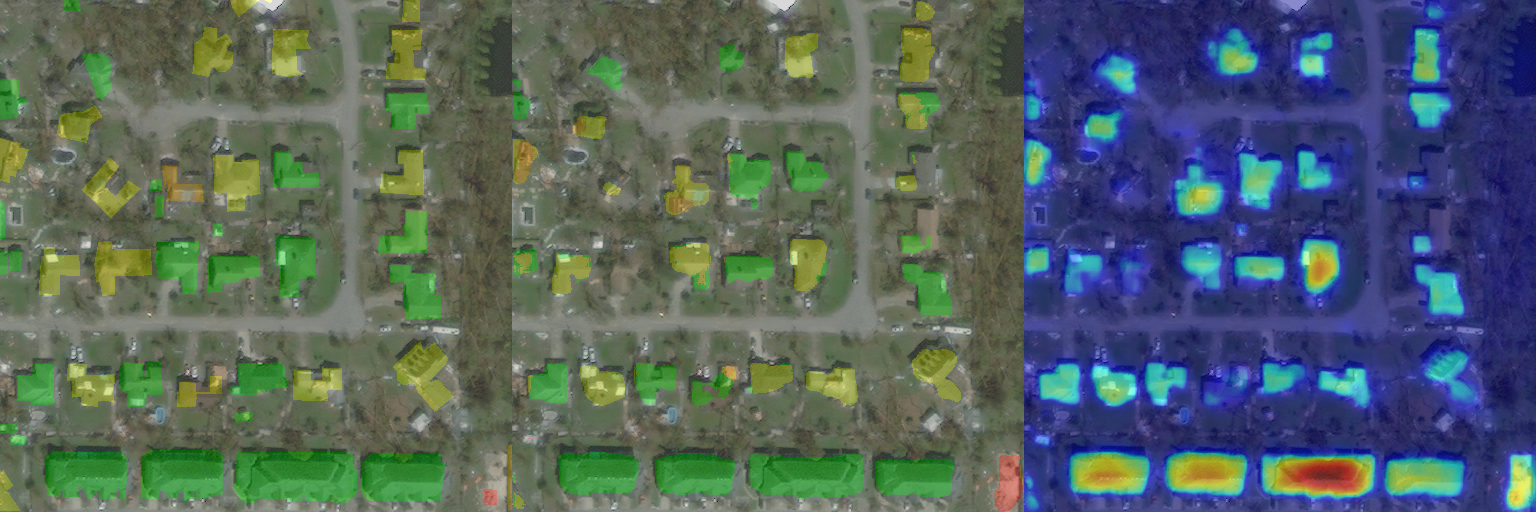

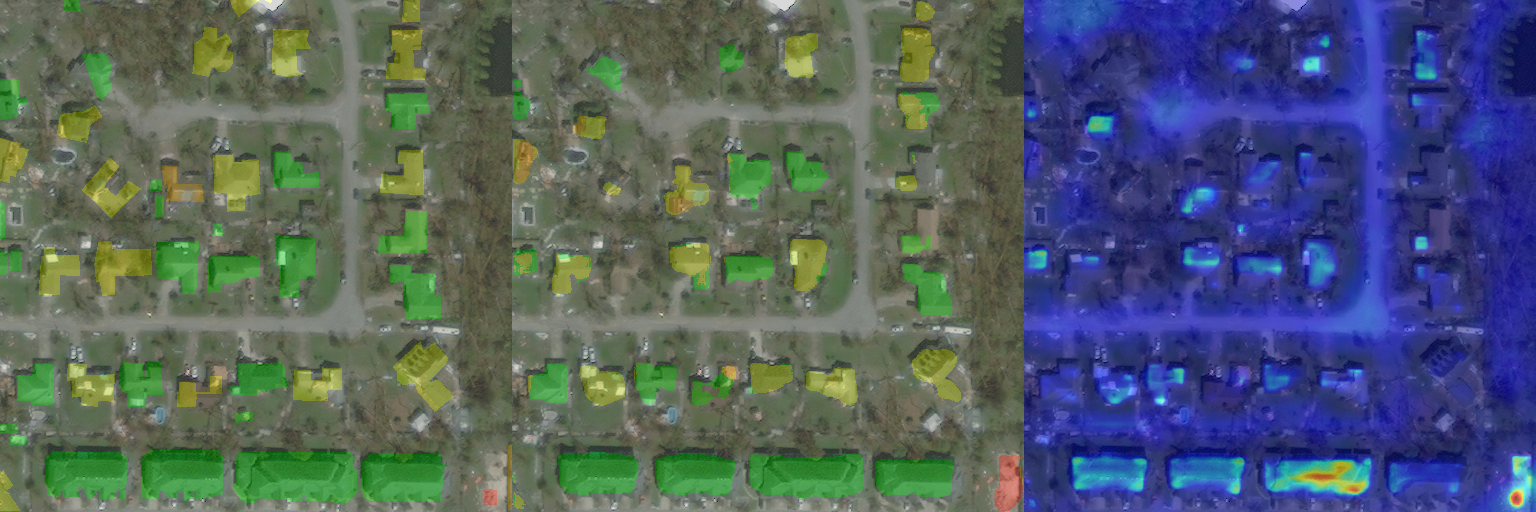

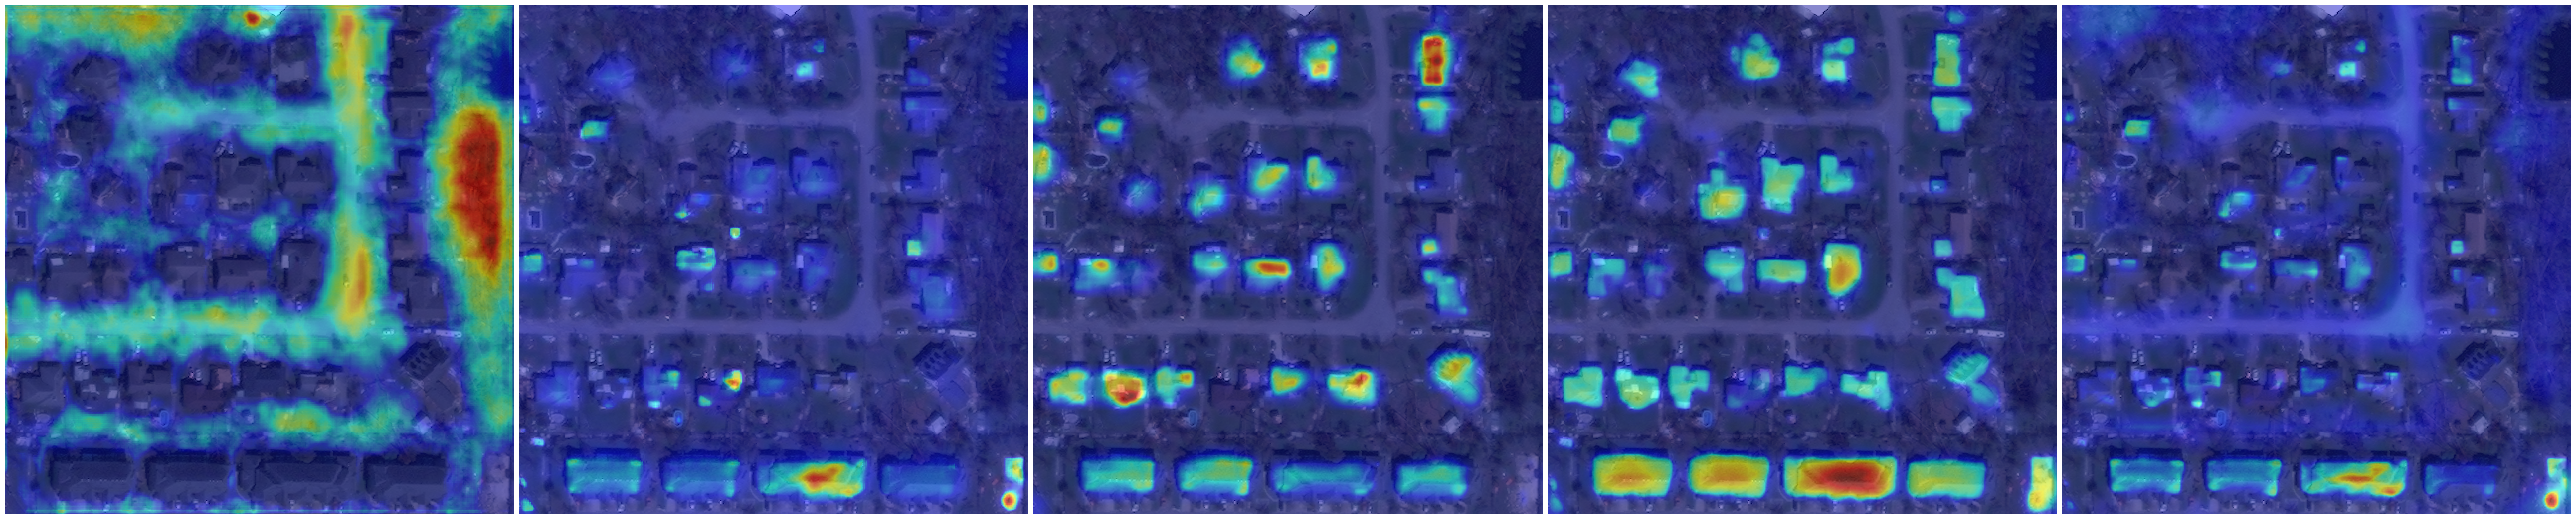

In [8]:
# IMG_NAME = "hurricane-matthew_00000106_post_disaster_patch3"
# IMG_NAME = "palu-tsunami_00000018_post_disaster_patch1"
# IMG_NAME = "palu-tsunami_00000093_post_disaster_patch2"
# IMG_NAME = "hurricane-michael_00000280_post_disaster_patch2"
# IMG_NAME = "palu-tsunami_00000063_post_disaster_patch2"
# IMG_PATH_POST = Path(f"data/xBD_processed_512/images/hold/images/{IMG_NAME}.png")

IMG_NAME = "hurricane-michael_00000051_post_disaster_patch1"
IMG_PATH_POST = Path(f"data/xBD_processed_512/images/tier1/images/{IMG_NAME}.png")

# FarSeg
# target_layers = model.model.module.decoder.blocks

# Baseline
target_layers = [
    model.model.conv6_2,
    model.model.conv7_2,
    model.model.conv8_2,
    model.model.conv9_2,
    model.model.conv10,
    model.model.res,
]

# region boring
item = dm._test_dataset[dm._test_dataset._image_paths_post.index(IMG_PATH_POST)]
image_pre, mask_pre, image_post, mask_post = item

with torch.no_grad():
    m = model.to(device)
    preds = m(torch.cat([torch.unsqueeze(image_pre, 0), torch.unsqueeze(image_post, 0)], dim=1).to(device))

for c in range(0, 5):

    targets = [SemanticSegmentationTarget(c, mask_post.argmax(axis=0))]
    with GradCAM(
        model=model,
        target_layers=target_layers,
    ) as cam:
        grayscale_cam = cam(input_tensor=torch.unsqueeze(torch.cat([image_pre, image_post], dim=0), 0), targets=targets)[
            0, :
        ]
        cam_image = show_cam_on_image(
            ((image_post + 1) / 2).moveaxis(0, -1).detach().cpu().numpy(), grayscale_cam, use_rgb=True
        )

    colors = [
        (128, 128, 128),
        (0, 255, 0),
        (244, 255, 0),
        (255, 174, 0),
        (255, 0, 0),
        (255, 255, 255),
    ]
    preds_masks = draw_segmentation_masks(
        ((image_post + 1) * 127.5).to(torch.uint8), torch.nn.functional.one_hot(preds[0].argmax(dim=0), num_classes=5).moveaxis(-1, 0).to(bool), colors=colors, alpha=0.3
    )
    ground_truth_masks = draw_segmentation_masks(
        ((image_post + 1) * 127.5).to(torch.uint8), mask_post.to(bool), colors=colors, alpha=0.3
    )
    comp = np.hstack((ground_truth_masks.moveaxis(0, -1).detach().cpu().numpy(), preds_masks.moveaxis(0, -1).detach().cpu().numpy(), cam_image))
    display(Image.fromarray(comp))

acts = []
for c in range(0, 5):
    targets = [SemanticSegmentationTarget(c, mask_post.argmax(axis=0))]
    with GradCAM(
        model=model,
        target_layers=target_layers,
    ) as cam:
        grayscale_cam = cam(input_tensor=torch.unsqueeze(torch.cat([image_pre, image_post], dim=0), 0), targets=targets)[
            0, :
        ]
        cam_image = show_cam_on_image(
            ((image_post + 1) / 2).moveaxis(0, -1).detach().cpu().numpy(), grayscale_cam, use_rgb=True
        )

    acts.append(torch.from_numpy(cam_image).moveaxis(-1, 0))
comp_acts = make_grid(torch.stack(acts), padding=5, pad_value=255)
display(Image.fromarray(comp_acts.moveaxis(0, -1).numpy()))

# endregion